In [30]:
# Imports
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler
from deep_translator import GoogleTranslator
import re
import cv2
import numpy as np
import ezdxf

# device to be used
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

Using device cpu


In [31]:
def hebrew_translator(user_prompt):
    """
    function for testing whether user's input is in Hebrew or in English - if it's
    in Hebrew then it will translate it to English
    :param user_prompt:
    :return:
    """
    contains_hebrew = re.search(r"[\u0590-\u05FF]", user_prompt) is not None
    if contains_hebrew:
        return GoogleTranslator(source='auto', target='en').translate(user_prompt)
    else:
        prompt_en = user_prompt

    return prompt_en

In [49]:
def add_nikud(text):
    """
    שואלת את המשתמש לגבי אותיות בעייתיות (ב, כ, פ),
    ומחזירה גרסה "מנוקדת" שבה דגש מסומן באות + U+05BC.
    """

    DAGESH = '\u05BC'
    ambiguous = ['ב', 'כ', 'פ']

    result = ""

    for ch in text:
        if ch in ambiguous:
            # שואלים את המשתמש
            ans = input(f"האם האות '{ch}' במילה '{text}' היא עם דגש? (y/n) ").strip().lower()

            if ans == 'y':
                result += ch + DAGESH   # הוספת דגש
            else:
                result += ch
        else:
            result += ch

    return result

In [50]:
# Braille
# ==========================================================
# זיהוי ניקוד — כולל דגש
# ==========================================================
DAGESH = '\u05BC'  # נקודה במרכז האות

def has_dagesh(char):
    # מחזיר True אם יש דגש על האות
    return DAGESH in char


# ==========================================================
# טבלת ברייל עברית — בסיסית
# ==========================================================

# אותיות ללא דגש
HEBREW_MAP = {
    'א': '⠁',
    'ב': '⠧',  # ללא דגש → v
    'ג': '⠛',
    'ד': '⠙',
    'ה': '⠓',
    'ו': '⠺',
    'ז': '⠵',
    'ח': '⠭',
    'ט': '⠞',
    'י': '⠚',
    'כ': '⠡',  # כ רפויה
    'ל': '⠇',
    'מ': '⠍',
    'נ': '⠝',
    'ס': '⠎',
    'ע': '⠫',
    'פ': '⠋',  # פ רפויה (f)
    'צ': '⠮',
    'ק': '⠟',
    'ר': '⠗',
    'ש': '⠩',  # SH
    'ת': '⠹'
}

# אותיות עם דגש (כמו בּ, כּ, פּ)
HEBREW_DAGESH_MAP = {
    'ב': '⠃',  # B
    'כ': '⠅',  # K
    'פ': '⠏',  # P
}

FINAL_FORMS = {
    'ך': 'כ',
    'ם': 'מ',
    'ן': 'נ',
    'ף': 'פ',
    'ץ': 'צ',
}

# ==========================================================
# תרגום לברייל → לפי ניקוד
# ==========================================================

def letter_to_braille(char):
    """
    מקבלת אות מנוּקֶדת (למשל 'בּ' או 'פ') ומחזירה ברייל נכון.
    """

    base = char[0]  # האות עצמה
    # אם סוף מילה → להמיר לצורה הרגילה
    if base in FINAL_FORMS:
        base = FINAL_FORMS[base]

    # אם יש דגש → מפה מיוחדת
    if has_dagesh(char):
        if base in HEBREW_DAGESH_MAP:
            return HEBREW_DAGESH_MAP[base]

    # אם אין דגש → מפה רגילה
    return HEBREW_MAP.get(base, base)


# ==========================================================
# תרגום משפט שלם לברייל
# ==========================================================

def convert_to_braille(text):
    #accepting a vowled hebrew word
    result = []

    for ch in text:
        # דילוג על סימני ניקוד פרט לדגש
        if ch >= '\u0591' and ch <= '\u05C7':
            # נשאיר רק דגש (אות + דגש ביחד כבר בזיהוי)
            continue

        # אותיות בעברית
        if 'א' <= ch <= 'ת':
            result.append(letter_to_braille(ch))
        else:
            # תווים זרים או רווח
            result.append(ch)

    return "".join(result)

In [34]:
def convert_tensor_to_pil_img(tensor):
    """
    function converts a tensor of size CxHxW in [-1,1] to a PIL image in [0,255]
    :param x (torch.Tensor): input tensor.
    :return image (PIL.Image): output image.
    """
    image = (tensor / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
    image = Image.fromarray(image)
    return image

In [35]:
def img_to_dxf(img_location, dxf_location="output.dxf"):
    # Load image
    img = cv2.imread(img_location, cv2.IMREAD_GRAYSCALE)

    # Threshold to black/white
    _, th = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)

    # Find contours
    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create DXF
    doc = ezdxf.new()
    msp = doc.modelspace()

    for cnt in contours:
        # Convert contour to (x, y) points
        points = [(float(p[0][0]), float(p[0][1])) for p in cnt]
        # Add polyline to DXF
        msp.add_lwpolyline(points, close=True)

    doc.saveas(dxf_location)

In [54]:
# general settings of Stable Diffusion
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 25  # Number of denoising steps
guidance_scale = 7.5  # Scale for classifier-free guidance
generator = torch.Generator(device)
checkpoint_stable = "runwayml/stable-diffusion-v1-5"

# image encoder and decoder (VAE)
vae = AutoencoderKL.from_pretrained(checkpoint_stable, subfolder="vae", use_safetensors=True)

# CLIP tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained(checkpoint_stable, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(checkpoint_stable, subfolder="text_encoder", use_safetensors=True)

# denoising U-Net model
unet = UNet2DConditionModel.from_pretrained(checkpoint_stable, subfolder="unet", use_safetensors=True)

# scheduler
scheduler = LMSDiscreteScheduler.from_pretrained(checkpoint_stable, subfolder="scheduler")
scheduler.set_timesteps(num_inference_steps)

# move everything to the GPU
vae.to(device)
text_encoder.to(device)
unet.to(device)
print("Loaded all components!")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loaded all components!


  0%|          | 0/25 [00:00<?, ?it/s]

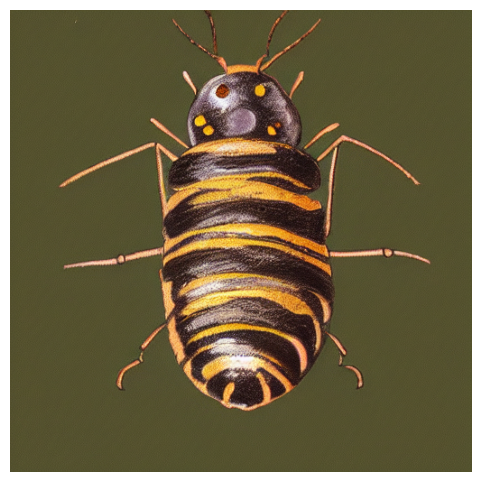

KeyboardInterrupt: Interrupted by user

In [55]:
## text to image generator from user's input ##
generator = torch.Generator(device)

# Cleaning prompt
torch.cuda.empty_cache()
latents = None
scheduler.set_timesteps(num_inference_steps)

# desired text prompt
hebrew_prompt  = input(" :בבקשה הכנס/י את התמונה שתרצי/שתרצה בספר")
general_prompt = hebrew_translator(hebrew_prompt)
type  = input(" :בבקשה הכנס/י את הקטגוריה של התמונה (פרי, ירק, מספר, אות)")
type = hebrew_translator(type)
user_prompt = f'ONLY ONE drawn {general_prompt} from the category {type}. Centered on a plain WHITE background.'
user_prompt = [user_prompt]
batch_size = len(user_prompt)

# tokenization
text_input = tokenizer(user_prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

# encoding with CLIP
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

# final text embeddings including unconditional for classifier guidance
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# initial noise in latent space
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    device=device,
)
latents = latents * scheduler.init_noise_sigma

# denoising in latent space
for t in tqdm(scheduler.timesteps):

    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    # scale model input at timestep t
    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform classifier free guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

    # scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# convert to image and show text to image generation result
image = convert_tensor_to_pil_img(image)
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis("off")
plt.show()



In [52]:
## Braille converter
hebrew_prompt = add_nikud(hebrew_prompt)
Braille = convert_to_braille(hebrew_prompt)
print(Braille)

⠵⠭⠇


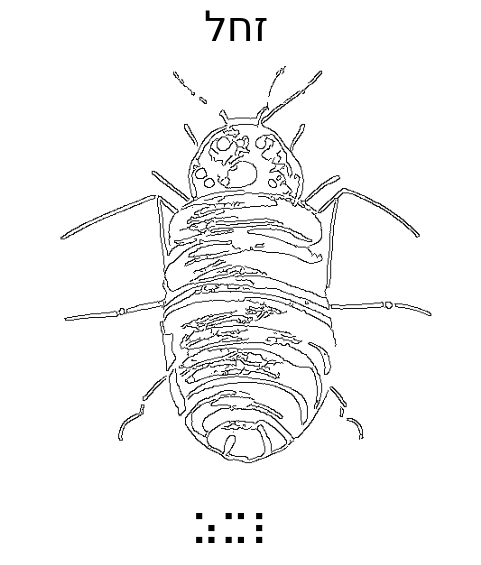

In [53]:
#image processing
image = np.array(image)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray_image, (5, 5), 0)
edges = cv2.Canny(blur, 50, 150)
kernel = np.ones((1, 1), np.uint8)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
edges = cv2.bitwise_not(edges)
h, w = edges.shape
edges[h-1:h, w-1:w] = 255


#centering object
h, w = edges.shape
ys, xs = np.where(edges[1:h-1,1:w-1] == 0)
obj_cx = xs.mean()
obj_cy = ys.mean()
img_cx = w / 2
img_cy = h / 2
shift_x = int(img_cx - obj_cx)
shift_y = int(img_cy - obj_cy)
M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
centered = cv2.warpAffine(edges, M, (w, h), borderValue=255)

#plotting final result
plt.figure(figsize=(6,6))
plt.text(250, -10, f'{hebrew_prompt[::-1]}', fontsize=30, color='black', ha='center') #English text
plt.text(250, 550, f'{Braille}', fontsize=30, color='black', ha='center') #Braille text
plt.imshow(centered, cmap="gray")
plt.axis("off")
plt.show()


In [28]:
# Saving as dxfd
filename = "output.png"
cv2.imwrite(filename, centered)
img_to_dxf(filename)